In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

#for python and R interoperability
import anndata2ri
import rpy2.robjects as robjects
anndata2ri.activate()
%load_ext rpy2.ipython

Install scRNAseq package if not already

In [2]:
# %R BiocManager::install("scRNAseq")

In [3]:
%%R 
suppressPackageStartupMessages(library(scRNAseq))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(flexmix))
suppressPackageStartupMessages(library(miQC))

# miQC 

Repeating from miQC documentation

R[write to console]: snapshotDate(): 2023-10-24

R[write to console]: see ?scRNAseq and browseVignettes('scRNAseq') for documentation

R[write to console]: loading from cache

R[write to console]: see ?scRNAseq and browseVignettes('scRNAseq') for documentation

R[write to console]: loading from cache

R[write to console]: see ?scRNAseq and browseVignettes('scRNAseq') for documentation

R[write to console]: loading from cache

R[write to console]: snapshotDate(): 2023-10-24

R[write to console]: see ?scRNAseq and browseVignettes('scRNAseq') for documentation

R[write to console]: loading from cache



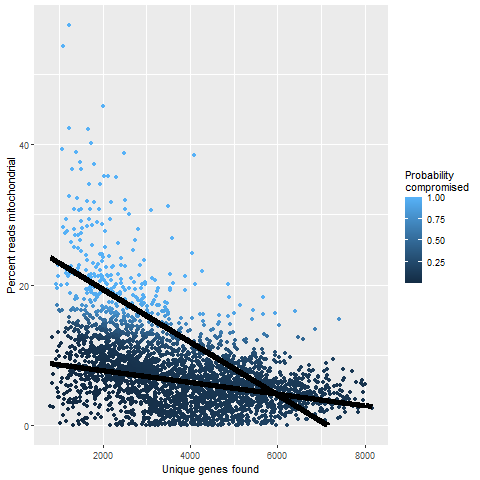

In [4]:
%%R -o adata_zeisel #convert singlecellexperiment to anndata

adata_zeisel = ZeiselBrainData()

sce = adata_zeisel

mt_genes <- grepl("^mt-",  rownames(sce))
feature_ctrls <- list(mito = rownames(sce)[mt_genes])

sce <- addPerCellQC(sce, subsets = feature_ctrls)

model <- mixtureModel(sce)

plotModel(sce, model)

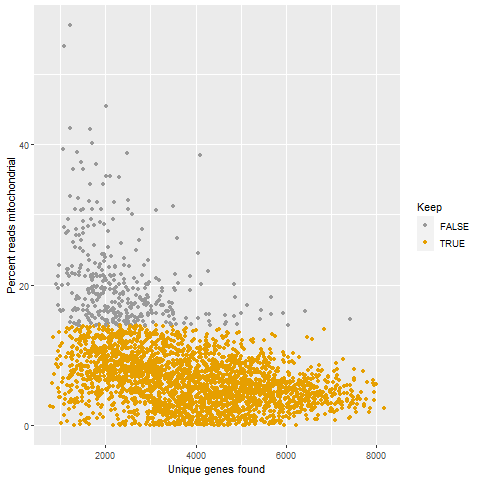

In [5]:
%%R 
plotFiltering(sce, model)

In [6]:
%%R
sce <- filterCells(sce, model)

Removing 359 out of 3005 cells.

# Python implementation

In [7]:
adata_zeisel.var['mt'] = adata_zeisel.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'

In [8]:
sc.pp.calculate_qc_metrics(adata_zeisel, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #calculate qc metrics

In [9]:
from sklearn.exceptions import ConvergenceWarning

def mixture_model(adata, detected="n_genes_by_counts", subsets_mito_percent="pct_counts_mt", plot=True):
    metrics = adata.obs #extract obs from anndata
    X = metrics[[detected, subsets_mito_percent]].values #store the values we want to use for mixture models

    bgmm = BayesianGaussianMixture(n_components=2, covariance_type="full", random_state=42) #initialize the mixture model
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConvergenceWarning)
            bgmm.fit(X)
    except ConvergenceWarning:
        #this will raise error if number of components cannot converge. Mixture model may not be appropriate
        raise ValueError("Initialization did not converge. Check the data for 2 distributions")

    return(bgmm)


In [10]:
def plot_model(adata, detected="n_genes_by_counts", subsets_mito_percent="pct_counts_mt", contour=True):
    metrics = adata.obs
    X = metrics[[detected, subsets_mito_percent]].values
    model = mixture_model(adata)

    posterior_probs = model.predict_proba(X)
    
    prob_compromised = posterior_probs[:, 1]
    prob_intact = posterior_probs[:, 0]

    # Set the probability threshold for cells to keep

    # Create a new DataFrame with probability metrics
    metrics = pd.DataFrame({
        'n_genes_by_counts': metrics['n_genes_by_counts'],
        'pct_counts_mt': metrics['pct_counts_mt'],
        'prob_compromised': prob_compromised
    })

    # Create scatter plot with probability estimates as colors
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=metrics,
                    x='n_genes_by_counts',
                    y='pct_counts_mt',
                    hue='prob_compromised',
                    ax=ax,
                    palette='viridis')

    if contour:
        sns.kdeplot(data=metrics,
                    x='n_genes_by_counts',
                    y='pct_counts_mt',
                    ax=ax,
                    fill=True,
                    cmap='Reds',
                    alpha=0.3)

    ax.legend().remove()
    
    # Add colorbar with 'viridis' cmap
    for_cbar = plt.cm.ScalarMappable(cmap="viridis")
    for_cbar.set_array([])
    cbar = plt.colorbar(for_cbar, ax=ax, cmap='viridis')
    cbar.ax.set_ylabel('Probablity Compromised', rotation=270, labelpad=15)
    ax.set_xlabel("Detected Genes")
    ax.set_ylabel("Percent Mito")
    ax.set_title('Scatter Plot with BGMM Clustering')
    plt.show()

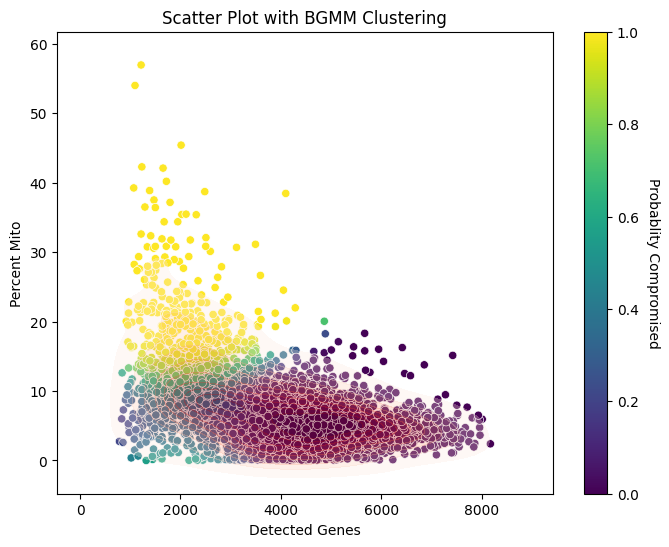

In [11]:
plot_model(adata_zeisel, contour=True)

In [12]:
def plotfiltering(adata, detected="n_genes_by_counts", subsets_mito_percent="pct_counts_mt", threshold=0.9):
    
    #extract qc metrics
    metrics = adata.obs
    
    #extracting columns and setting into array
    X = metrics[[detected, subsets_mito_percent]].values

    #mixture model
    model = mixture_model(adata)

    #extract posterior probabilities belong to each component from the model
    posterior_probs = model.predict_proba(X)
    
    #assuming component one is compromised cell component
    prob_compromised = posterior_probs[:, 1]
    prob_intact = posterior_probs[:, 0]

    # Set the probability threshold for cells to keep
    keep = prob_compromised <= threshold

    # Create a new DataFrame with probability metrics
    metrics = pd.DataFrame({
        'n_genes_by_counts': metrics['n_genes_by_counts'],
        'pct_counts_mt': metrics['pct_counts_mt'],
        'prob_compromised': prob_compromised,
        'intact': keep
    })

    # Create a GLM to predict 'pct_counts_mt' from 'n_genes_by_counts'
    X_glm = sm.add_constant(metrics['n_genes_by_counts'])
    y_glm = metrics['pct_counts_mt']
    glm_model = sm.GLM(y_glm, X_glm, family=sm.families.Gaussian())
    glm_results = glm_model.fit()

    # Extract the predicted values from the GLM
    predictions = glm_results.predict(X_glm)
    metrics['intact_prediction'] = predictions
    #here we are going to make sure that cells with low mito content are not removed as per miQC
    metrics.loc[metrics['pct_counts_mt'] < metrics['intact_prediction'], 'intact'] = True

    #this is to prevent the U-shape formation
    min_discard = min(metrics[~metrics['intact']]['pct_counts_mt']) #minimum of percent mito
    min_index = metrics[metrics['pct_counts_mt'] == min_discard].index[0] #find the index
    lib_complexity = metrics.loc[min_index]['n_genes_by_counts'] #extract detected genes
    #set everything to the left of the minimum with higher mito to False
    metrics.loc[
        (metrics['n_genes_by_counts'] <= lib_complexity) & (metrics['pct_counts_mt'] >= min_discard), 'intact'] = False

    # Create scatter plot with filtering
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=metrics, x='n_genes_by_counts', y='pct_counts_mt', hue='intact', ax=ax)
    
    ax.set_xlabel("Detected Genes")
    ax.set_ylabel("Percent Mito")
    ax.set_title('Compromised Cell Filtering')
    plt.show()

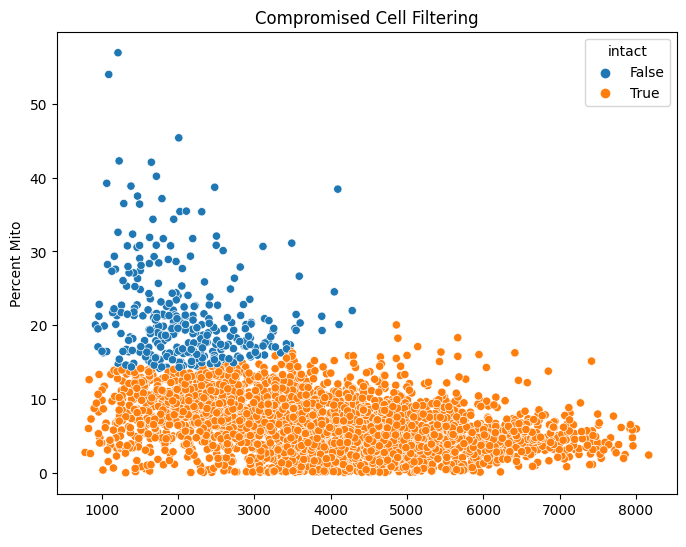

In [13]:
plotfiltering(adata_zeisel, threshold=0.9)

In [14]:
def filtercells(adata, detected="n_genes_by_counts", subsets_mito_percent="pct_counts_mt", threshold=0.9, inplace=True):
    
    #extract qc metrics
    metrics = adata.obs
    
    #extracting columns and setting into array
    X = metrics[[detected, subsets_mito_percent]].values

    #mixture model
    model = mixture_model(adata)

    #extract posterior probabilities belong to each component from the model
    posterior_probs = model.predict_proba(X)
    
    #assuming component one is compromised cell component
    prob_compromised = posterior_probs[:, 1]
    prob_intact = posterior_probs[:, 0]

    # Set the probability threshold for cells to keep
    keep = prob_compromised <= threshold

    # Create a new DataFrame with probability metrics
    metrics = pd.DataFrame({
        'n_genes_by_counts': metrics['n_genes_by_counts'],
        'pct_counts_mt': metrics['pct_counts_mt'],
        'prob_compromised': prob_compromised,
        'intact': keep
    })

    # Create a GLM to predict 'pct_counts_mt' from 'n_genes_by_counts'
    X_glm = sm.add_constant(metrics['n_genes_by_counts'])
    y_glm = metrics['pct_counts_mt']
    glm_model = sm.GLM(y_glm, X_glm, family=sm.families.Gaussian())
    glm_results = glm_model.fit()

    # Extract the predicted values from the GLM
    predictions = glm_results.predict(X_glm)
    metrics['intact_prediction'] = predictions
    #here we are going to make sure that cells with low mito content are not removed as per miQC
    metrics.loc[metrics['pct_counts_mt'] < metrics['intact_prediction'], 'intact'] = True

    #this is to prevent the U-shape formation
    min_discard = min(metrics[~metrics['intact']]['pct_counts_mt']) #minimum of percent mito
    min_index = metrics[metrics['pct_counts_mt'] == min_discard].index[0] #find the index
    lib_complexity = metrics.loc[min_index]['n_genes_by_counts'] #extract detected genes
    #set everything to the left of the minimum with higher mito to False
    metrics.loc[
        (metrics['n_genes_by_counts'] <= lib_complexity) & (metrics['pct_counts_mt'] >= min_discard), 'intact'] = False

    num_removed_cells = len(metrics[metrics['intact'] == False])

    print(f'Removing {num_removed_cells} compromised cells')
    
    adata.obs = metrics.copy()

    if inplace:
        adata._inplace_subset_obs(adata.obs['intact'] == True)
    else:
        return adata[adata.obs['intact'] == True]

In [15]:
filtercells(adata_zeisel, threshold=0.9, inplace=True)

Removing 319 compromised cells


One thing about using the bayesian gaussian mixture model, cells with a higher number of detected genes appear to be favored for keeping when compared to the flexmix linear modeling implementation. This helps to highlight the adaptive framework of this method wherein as library complexity increases, the predicted assignment to a compromised cell decreases, which intuitively makes sense. However, more experimentation and validation is certainly needed.